Zero-shot Topic modelling: https://maartengr.github.io/BERTopic/getting_started/zeroshot/zeroshot.html#example

In [1]:
import pandas as pd
import math
import re

Note there's a bug/feature of the below function that's sort of the nature of natural language.
If you split by "." you might occasionally split at an important point: 
"I stocked up on supplies e.g. baked beans" would get split into "I stocked up on supplies e", "g" and "baked beans". 

Use this approach with caution and check the outputs!

In [2]:
def split_and_update_indices(test_list, test_index, split_list):
    """
    Splits elements in a list based on a list of splitters and updates the index list accordingly.
    Useful below for keeping track of who said what from topic modelling whilst splitting longer responses.

    Parameters
    test_list : list
        List of strings to split.
    test_index : list
        List of indices corresponding to the strings in test_list.
    split_list : list
        List of strings to split on.

    Returns
    new_list : list
        List of strings split on the splitters.
    new_index : list
        List of indices corresponding to the strings in new_list.
    """
    new_list = []
    new_index = []

    for element, index in zip(test_list, test_index):
        split_elements = [element]
        for splitter in split_list:
            temp_list = []
            for sub_element in split_elements:
                temp_list.extend(sub_element.split(splitter))
            split_elements = temp_list
        
        # Remove empty strings resulting from split
        split_elements = [elem for elem in split_elements if elem]

        new_list.extend(split_elements)
        new_index.extend([index] * len(split_elements))

    return new_list, new_index

# Example usage
Test_list = ["Sentence. New sentence and a bit more", "Something else", "More stuff and even more"]
Test_index = [0, 1, 2]
SplitList = [".", " and"]

New_list, New_index = split_and_update_indices(Test_list, Test_index, SplitList)

print(New_list)
print(New_index)

['Sentence', ' New sentence', ' a bit more', 'Something else', 'More stuff', ' even more']
[0, 0, 0, 1, 2, 2]


In [3]:
def data_loader(DataSet="Heat", SplitterList=[". ", ", ", "-", "and", ";"], Type="Split"):
    """
    Load in the dataset, process it into a list of data.
        
    Parameters:
    DataSet (str): The dataset to load in. Options are "Heat", "Cold" or "Flood".
    SplitterList (list): List of strings to split the documents by, only applies if Type is "Split".
    Type (str): The type of processing to apply to the dataset. Options are "Split" or "Combine".

    If Type = "Combine" then any info from all 3 potential columns are combined into 1 entry per person.
    This appears ideal but the larger the sentence, the harder it is for BERT to deduce what sentences are similar.

    If Type = "Split" then the data is split by the SplitterList and each entry is split into multiple entries.
    A separate index is outputted which corresponds to the original data for each entry in the list 
    (this even works for the splitter option).

    Returns:
    docs (list): List of strings to use for topic modelling.
    doc_index (list): List of indices corresponding to the strings in docs.
    zero_shot_topic_list_major (list): List of major topics for zero-shot classification.
    zero_shot_topic_list_minor (list): List of minor topics for zero-shot classification.
    """
    
    if DataSet == "Heat":
        # Heat Data
        RawText = pd.read_excel("HeatSurvey23 Analysis_Free TextHuwsCopy.xlsx", sheet_name="Huws Breakdown (2)")
        RawTextAnalysis = RawText[["ADVNC_TEXT", "WTHR_TEXT", "FREE_TEXT"]]

        zero_shot_topic_list_major = ["Routine", "Technology solution", "Home adaptations", "Personal care"]
        zero_shot_topic_list_minor = ["Alternative plans", "Time of day", "Reduced activity", 
                                          "Benefit", "Physical health", "Cooling", "Sun protection", 
                                          "Care", "Fan", "Air conditioning", "Closed curtains or blinds", 
                                          "Lighter bedding"]
    elif DataSet == "Cold":
        # Cold Data
        RawText = pd.read_excel("ColdFloodSurvey24 AnalysisHuwsCopy.xlsx", sheet_name="HuwsDATA", header=1)
        RawTextAnalysis = RawText[["ADVNC_TEXT_C", "WTHR_TEXT_C", "FREE_TEXT_C"]] 

        zero_shot_topic_list_major = ["Routine", "Technology solution", "Home adaptations", "Personal care", "Safety precautions"]
        zero_shot_topic_list_minor = ["Time of day", "Alternative plans", "Reduced activity", "Benefit", "Physical health", 
                                          "Extra Heating", "Dehumidifier", "Blankets", "Insulation", "Layers", "Hot water bottle", 
                                          "Hot drinks", "Bigger meals", "Car", "Pipes", "Supplies", "Family"]
    elif DataSet == "Flood":    
        # Storm Data
        RawText = pd.read_excel("ColdFloodSurvey24 AnalysisHuwsCopy.xlsx", sheet_name="HuwsDATA", header=1)
        RawTextAnalysis = RawText[["ADVNC_TEXT_F", "WTHR_TEXT_F", "FREE_TEXT_F"]]

        zero_shot_topic_list_major = ["Routine", "Technology solution", "Personal care", "Safety precautions"]
        zero_shot_topic_list_minor = ["Time of day", "Alternative plans", "Reduced activity", "Heating", "Clothing", "Secure loose objects", "Drainage"]
    else:
        print("Invalid DataSet")
        exit()
    
    print("Data loaded: ", DataSet)
    print("Number of rows: ", RawTextAnalysis.shape[0])
    # Find how many rows have only NaNs or missing values
    missing_values_count = RawTextAnalysis.isnull().all(axis=1).sum()
    print("Number of rows with no responses: ", missing_values_count)
    print("Percentage of rows with no responses: ", missing_values_count / RawTextAnalysis.shape[0] * 100)

    #HeatTextAnalysis = HeatText[["ADVNC_TEXT", "WTHR_TEXT", "OTHR_TEXT", "FREE_TEXT"]]
    #.drop(["ID", "WTHR", "OTHR", "ALERT", "ADVNC", "HEALTH", "Health Conditions", "Symtoms1", "Symtoms2", "Symtoms3"], axis=1)
    if Type == "Split":
        data = RawTextAnalysis.values.flatten().tolist()
        dataset_size = len(data)
        # Remove NaN values from the list
        docs = [value for value in data if not (isinstance(value, float) and math.isnan(value))]
        removed_size = len(docs)

        print("List length: ", dataset_size)
        print("Removed NaN values from list: ", dataset_size - removed_size)
        print("Percentage non-responses removed: ", (dataset_size - removed_size) / dataset_size * 100)
        print("Final dataset size: ", removed_size)

        doc_index = []
        for element in docs:
            doc_index.append(data.index(element))
        
        if len(SplitterList) > 0:
            print("Length of docs before splitting: ", len(docs))
            print("Items to split by: ", SplitterList)
            docs, doc_index = split_and_update_indices(docs, doc_index, SplitterList)
            print("Length of docs after splitting: ", len(docs))

    elif Type == "Combine":
        dataset_size = RawTextAnalysis.shape[0]
        dataset = RawTextAnalysis.dropna(how="all")
        doc_index = dataset.index.tolist()
        removed_size = dataset.shape[0]

        print("List length: ", dataset_size)
        print("Removed NaN values from list: ", dataset_size - removed_size)
        print("Percentage non-responses removed: ", (dataset_size - removed_size) / dataset_size * 100)
        print("Final dataset size: ", removed_size)

        docs = []

        for row in dataset.iterrows():
            values = row[1].dropna().values
            #print(values)
            value_combined = ". ".join([str(value) for value in values if value is not None])
            #print(value_combined)
            #print("")
            docs.append(value_combined)

        doclen = len(docs)    
        docs = [doc for doc in docs if re.search('[a-zA-Z]', doc)]
        if doclen != len(docs):
            print("Removed empty strings from dataset")
            print("Length of docs after processing: ", len(docs))
                     
    return docs, doc_index, zero_shot_topic_list_major, zero_shot_topic_list_minor


In [4]:
# Heat, Heat_index, major_topics_heat, minor_topics_heat = data_loader("Heat", Type="Split", SplitterList=[".", "and"])
# print("")
# print(len(Heat), len(Heat_index))
# print("")

# Cold, Cold_index, major_topics_cold, minor_topics_cold = data_loader("Cold")
# print("")
# print("Has the index updated worked: ", len(Cold)==len(Cold_index))
# print("")

# Flood, Flood_index, major_topics_flood, minor_topics_flood = data_loader("Flood")
# print("")
# print("Has the index updated worked: ", len(Flood)==len(Flood_index))
# print("")

In [5]:
Name = "Cold" # Set this to be one of the following: "Heat", "Cold", "Flood"

docs, docs_index, zero_shot_topic_list_major, zero_shot_topic_list_minor = data_loader(Name)
print("")

# print("Example docs: ")
# for doc in docs[:15]:
#     print(doc)

Data loaded:  Cold
Number of rows:  2736
Number of rows with no responses:  1474
Percentage of rows with no responses:  53.87426900584795
List length:  8208
Removed NaN values from list:  6331
Percentage non-responses removed:  77.13206627680313
Final dataset size:  1877
Length of docs before splitting:  1877
Items to split by:  ['. ', ', ', '-', 'and', ';']
Length of docs after splitting:  3237



You can remove stop works that include stuff like "see previous question" or "no answer" this only removes them from the representation of the data, not the actual data.
If you remove all the viable representation then you'll still get topic clusters but they'll just have no representation!

In [6]:
import nltk
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

#free_s_w = ["see", "previous", "question", "made", "sure", "nope", "no", "thanks", "thank", "you"] 
#stop_words.extend(free_s_w)

# Print stop words across several lines to make it easier to read
for i in range(0, 5):
    print(stop_words[i:i+10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
['me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've"]
['my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll"]
['myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd"]
['we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your']


In [7]:
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer


# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Step 1 is by far the longest part of the process, so I recommend running this as few times as possible, especially for larger datasets

c:\Users\hd15639\AppData\Local\anaconda3\envs\Bertopic\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 102/102 [00:05<00:00, 20.37it/s]


In [8]:
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=20, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
# High number of nearest neighbors and low minimum distance can help to preserve local structure

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=60, min_samples=1, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# The parameter "min_cluster_size" here lets you indirectly influence the number of clusters by setting a minimum size for each cluster.
# Setting "min_samples" to a lower value can help you reduce the size of the outliers cluster.

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words=stop_words, min_df=1, ngram_range=(1,3))

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations
representation_model = MaximalMarginalRelevance(diversity=0.7)

# All steps together
BERT_model = BERTopic(
    embedding_model=embedding_model,          # Step 1 - Extract embeddings
    umap_model=umap_model,                    # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
    representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations

    #zeroshot_topic_list=zero_shot_topic_list_minor, zeroshot_min_similarity=0.9, # Comment this out if you don't want zero-shot
    # 0 similarity = only use my topic lists, 1 similarity = barely pay attention to my topic lists.
)

In [9]:
topics, _ = BERT_model.fit_transform(docs)

# # You can also reduce outliers after BERTopic has been fitted
# new_topics = BERT_model.reduce_outliers(docs, topics)

# # Reduce outliers with pre-calculate embeddings instead
# new_topics = BERT_model.reduce_outliers(docs, topics, strategy="embeddings", embeddings=embeddings)


In [10]:
doc_inf = BERT_model.get_document_info(docs)
doc_inf["Person_id"] = docs_index
doc_inf.to_csv(f"BERTModelRawOutputs/{Name}_Document_Info.csv")
#doc_inf.head()

In [11]:
top_inf = BERT_model.get_topic_info()
# Calculate the number of unique person IDs per topic
unique_person_ids_per_topic = doc_inf.groupby('Topic')['Person_id'].nunique().reset_index()
unique_person_ids_per_topic.columns = ['Topic', 'Unique_Person_Count']

# Merge with the topic information dataframe
top_inf = top_inf.merge(unique_person_ids_per_topic, on='Topic', how='left')
top_inf.to_csv(f"BERTModelRawOutputs/{Name}_Topic_Info.csv")
#top_inf.head()
#top_inf["Person count"] = BERT_model.get_topic_sizes()
# Topic -1 is the "outlier" topic

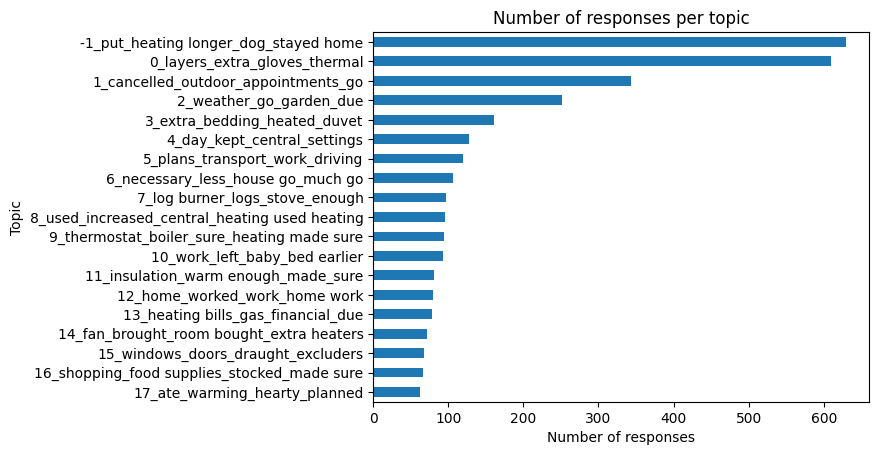

In [12]:
ax = doc_inf["Name"].value_counts(ascending=True).plot(kind='barh', xlabel="Number of responses", ylabel="Topic", title="Number of responses per topic")
fig3 = ax.get_figure()
fig3.savefig(f"BERTModelRawOutputs/{Name}_Number_of_responses_per_topic.png", bbox_inches='tight')

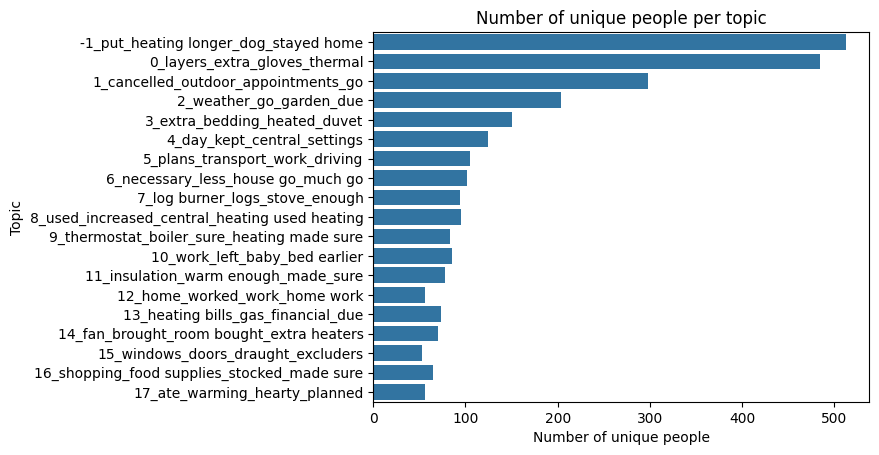

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create the bar plot
ax = sns.barplot(x="Unique_Person_Count", y="Name", data=top_inf)

# Set the labels and title
ax.set(xlabel="Number of unique people", ylabel="Topic", title="Number of unique people per topic")

# Show the plot
plt.show()
fig = ax.get_figure()
fig.savefig(f"BERTModelRawOutputs/{Name}_Number_of_unique_people_per_topic.png", bbox_inches='tight')

In [14]:
similar_topics, similarity = BERT_model.find_topics("elderly", top_n=5)
BERT_model.get_topic(similar_topics[0])

[('put', np.float64(0.028932036800500938)),
 ('heating longer', np.float64(0.02056825572165907)),
 ('dog', np.float64(0.020515220270674907)),
 ('stayed home', np.float64(0.020193498195717342)),
 ('wrapped', np.float64(0.0200402380712511)),
 ('used hot', np.float64(0.01932296833276391)),
 ('hot water bottles', np.float64(0.018671276332217438)),
 ('indoors', np.float64(0.012241009568070437)),
 ('times', np.float64(0.011881721302320188)),
 ('elderly', np.float64(0.011590844816327831))]

In [15]:
BERT_model.visualize_topics()

In [16]:
number_of_topics = len(BERT_model.get_topic_info())
fig = BERT_model.visualize_barchart(top_n_topics=number_of_topics)
fig

In [17]:
fig2 = BERT_model.visualize_hierarchy()
fig2

In [18]:
# topics_to_merge = [[1, 2]
#                    [3, 4]]
# BERT_model.merge_topics(docs, topics_to_merge)



#BERT_model.reduce_topics(docs, nr_topics=30)


# Topics_to_merge = []
# merge_list = []
# while True:
#     print("Current merge list: ", merge_list)
#     print("Current Topics_to_merge: ", Topics_to_merge)
#     topic = input("Enter topic numbers to merge, 'm' to conclude that merge list and 'q' to quit: ")
#     if topic == "q":
#         break
#     elif topic == "m":
#         if len(merge_list) > 1:
#             Topics_to_merge.append(merge_list)
#         merge_list = []
#     else:
#         merge_list.append(int(topic))
# if len(Topics_to_merge) > 0:
#     print("Topics_to_merge: ", Topics_to_merge)
#     BERT_model.merge_topics(docs=docs, topics_to_merge=Topics_to_merge)

In [19]:
# import plotly.graph_objects as go

# # Assuming `BERT_model` is already defined
# topic_info = BERT_model.get_topic_info()
# num_topics = len(topic_info) - 1  # Exclude the outlier topic (-1)

# topn_words = 4  # Number of top words to display for each topic

# labels = []
# parents = []
# values = []

# # Add topics to the sunburst plot
# for i in range(num_topics):
#     topic = BERT_model.get_topic(i)
#     topic_label = f"Topic {i+1}"
#     labels.append(topic_label)
#     parents.append("")
#     values.append(sum([weight for _, weight in topic[:topn_words]]))

#     # Add top words for each topic
#     for word, weight in topic[:topn_words]:
#         labels.append(word)
#         parents.append(topic_label)
#         values.append(weight)

# # Print lists for debugging
# print(labels)
# print(parents)
# print(values)

# # Create the sunburst plot
# fig = go.Figure(go.Sunburst(
#     labels=labels,
#     parents=parents,
#     values=values,
#     branchvalues="total",
#     hovertemplate='<b>%{label}</b><br>Weight: %{value:.2f}<extra></extra>',
# ))

# # Set the layout
# fig.update_layout(
#     title="BERTopic Model Sunburst Plot for Heat Survey",
#     margin=dict(t=50, l=0, r=0, b=0),
# )

# # Show the plot
# fig.show()